In [1]:
# This is RIPPED straight from the tmm package

from __future__ import division, print_function, absolute_import

from numpy import cos, inf, zeros, array, exp, conj, nan, isnan, pi, sin

import numpy as np
import scipy as sp

import sys
EPSILON = sys.float_info.epsilon

# helpers & imports
def make_2x2_array(a, b, c, d, dtype=float):
    """
    Makes a 2x2 numpy array of [[a,b],[c,d]]

    Same as "numpy.array([[a,b],[c,d]], dtype=float)", but ten times faster
    """
    my_array = np.empty((2,2), dtype=dtype)
    my_array[0,0] = a
    my_array[0,1] = b
    my_array[1,0] = c
    my_array[1,1] = d
    return my_array

def is_forward_angle(n, theta):
    """
    if a wave is traveling at angle theta from normal in a medium with index n,
    calculate whether or not this is the forward-traveling wave (i.e., the one
    going from front to back of the stack, like the incoming or outgoing waves,
    but unlike the reflected wave). For real n & theta, the criterion is simply
    -pi/2 < theta < pi/2, but for complex n & theta, it's more complicated.
    See https://arxiv.org/abs/1603.02720 appendix D. If theta is the forward
    angle, then (pi-theta) is the backward angle and vice-versa.
    """
    assert n.real * n.imag >= 0, ("For materials with gain, it's ambiguous which "
                                  "beam is incoming vs outgoing. See "
                                  "https://arxiv.org/abs/1603.02720 Appendix C.\n"
                                  "n: " + str(n) + "   angle: " + str(theta))
    ncostheta = n * cos(theta)
    if abs(ncostheta.imag) > 100 * EPSILON:
        # Either evanescent decay or lossy medium. Either way, the one that
        # decays is the forward-moving wave
        answer = (ncostheta.imag > 0)
    else:
        # Forward is the one with positive Poynting vector
        # Poynting vector is Re[n cos(theta)] for s-polarization or
        # Re[n cos(theta*)] for p-polarization, but it turns out they're consistent
        # so I'll just assume s then check both below
        answer = (ncostheta.real > 0)
    # convert from numpy boolean to the normal Python boolean
    answer = bool(answer)
    # double-check the answer ... can't be too careful!
    error_string = ("It's not clear which beam is incoming vs outgoing. Weird"
                    " index maybe?\n"
                    "n: " + str(n) + "   angle: " + str(theta))
    if answer is True:
        assert ncostheta.imag > -100 * EPSILON, error_string
        assert ncostheta.real > -100 * EPSILON, error_string
        assert (n * cos(theta.conjugate())).real > -100 * EPSILON, error_string
    else:
        assert ncostheta.imag < 100 * EPSILON, error_string
        assert ncostheta.real < 100 * EPSILON, error_string
        assert (n * cos(theta.conjugate())).real < 100 * EPSILON, error_string
    return answer

def list_snell(n_list, th_0):
    """
    return list of angle theta in each layer based on angle th_0 in layer 0,
    using Snell's law. n_list is index of refraction of each layer. Note that
    "angles" may be complex!!
    """
    # Important that the arcsin here is scipy.arcsin, not numpy.arcsin! (They
    # give different results e.g. for arcsin(2).)
    angles = sp.arcsin(n_list[0]*np.sin(th_0) / n_list)
    # The first and last entry need to be the forward angle (the intermediate
    # layers don't matter, see https://arxiv.org/abs/1603.02720 Section 5)
    if not is_forward_angle(n_list[0], angles[0]):
        angles[0] = pi - angles[0]
    if not is_forward_angle(n_list[-1], angles[-1]):
        angles[-1] = pi - angles[-1]
    return angles

def interface_t(polarization, n_i, n_f, th_i, th_f):
    """
    transmission amplitude (frem Fresnel equations)

    polarization is either "s" or "p" for polarization

    n_i, n_f are (complex) refractive index for incident and final

    th_i, th_f are (complex) propegation angle for incident and final
    (in radians, where 0=normal). "th" stands for "theta".
    """
    if polarization == 's':
        return 2 * n_i * cos(th_i) / (n_i * cos(th_i) + n_f * cos(th_f))
    elif polarization == 'p':
        return 2 * n_i * cos(th_i) / (n_f * cos(th_i) + n_i * cos(th_f))
    else:
        raise ValueError("Polarization must be 's' or 'p'")
    
def interface_r(polarization, n_i, n_f, th_i, th_f):
    """
    reflection amplitude (from Fresnel equations)

    polarization is either "s" or "p" for polarization

    n_i, n_f are (complex) refractive index for incident and final

    th_i, th_f are (complex) propegation angle for incident and final
    (in radians, where 0=normal). "th" stands for "theta".
    """
    if polarization == 's':
        return ((n_i * cos(th_i) - n_f * cos(th_f)) /
                (n_i * cos(th_i) + n_f * cos(th_f)))
    elif polarization == 'p':
        return ((n_f * cos(th_i) - n_i * cos(th_f)) /
                (n_f * cos(th_i) + n_i * cos(th_f)))
    else:
        raise ValueError("Polarization must be 's' or 'p'")

def R_from_r(r):
    """
    Calculate reflected power R, starting with reflection amplitude r.
    """
    return abs(r)**2

def T_from_t(pol, t, n_i, n_f, th_i, th_f):
    """
    Calculate transmitted power T, starting with transmission amplitude t.

    n_i,n_f are refractive indices of incident and final medium.

    th_i, th_f are (complex) propegation angles through incident & final medium
    (in radians, where 0=normal). "th" stands for "theta".

    In the case that n_i,n_f,th_i,th_f are real, formulas simplify to
    T=|t|^2 * (n_f cos(th_f)) / (n_i cos(th_i)).

    See manual for discussion of formulas
    """
    if pol == 's':
        return abs(t**2) * (((n_f*cos(th_f)).real) / (n_i*cos(th_i)).real)
    elif pol == 'p':
        return abs(t**2) * (((n_f*conj(cos(th_f))).real) /
                                (n_i*conj(cos(th_i))).real)
    else:
        raise ValueError("Polarization must be 's' or 'p'")
    
def power_entering_from_r(pol, r, n_i, th_i):
    """
    Calculate the power entering the first interface of the stack, starting with
    reflection amplitude r. Normally this equals 1-R, but in the unusual case
    that n_i is not real, it can be a bit different than 1-R. See manual.

    n_i is refractive index of incident medium.

    th_i is (complex) propegation angle through incident medium
    (in radians, where 0=normal). "th" stands for "theta".
    """
    if pol == 's':
        return ((n_i*cos(th_i)*(1+conj(r))*(1-r)).real
                     / (n_i*cos(th_i)).real)
    elif pol == 'p':
        return ((n_i*conj(cos(th_i))*(1+r)*(1-conj(r))).real
                      / (n_i*conj(cos(th_i))).real)
    else:
        raise ValueError("Polarization must be 's' or 'p'")

# This is the fn I care abt
def coh_tmm(pol, n_list, d_list, th_0, lam_vac):
    """
    Main "coherent transfer matrix method" calc. Given parameters of a stack,
    calculates everything you could ever want to know about how light
    propagates in it. (If performance is an issue, you can delete some of the
    calculations without affecting the rest.)

    pol is light polarization, "s" or "p".

    n_list is the list of refractive indices, in the order that the light would
    pass through them. The 0'th element of the list should be the semi-infinite
    medium from which the light enters, the last element should be the semi-
    infinite medium to which the light exits (if any exits).

    th_0 is the angle of incidence: 0 for normal, pi/2 for glancing.
    Remember, for a dissipative incoming medium (n_list[0] is not real), th_0
    should be complex so that n0 sin(th0) is real (intensity is constant as
    a function of lateral position).

    d_list is the list of layer thicknesses (front to back). Should correspond
    one-to-one with elements of n_list. First and last elements should be "inf".

    lam_vac is vacuum wavelength of the light.

    Outputs the following as a dictionary (see manual for details)

    * r--reflection amplitude
    * t--transmission amplitude
    * R--reflected wave power (as fraction of incident)
    * T--transmitted wave power (as fraction of incident)
    * power_entering--Power entering the first layer, usually (but not always)
      equal to 1-R (see manual).
    * vw_list-- n'th element is [v_n,w_n], the forward- and backward-traveling
      amplitudes, respectively, in the n'th medium just after interface with
      (n-1)st medium.
    * kz_list--normal component of complex angular wavenumber for
      forward-traveling wave in each layer.
    * th_list--(complex) propagation angle (in radians) in each layer
    * pol, n_list, d_list, th_0, lam_vac--same as input

    """
    # Convert lists to numpy arrays if they're not already.
    n_list = array(n_list)
    d_list = array(d_list, dtype=float)

    # Input tests
    if ((hasattr(lam_vac, 'size') and lam_vac.size > 1)
          or (hasattr(th_0, 'size') and th_0.size > 1)):
        raise ValueError('This function is not vectorized; you need to run one '
                         'calculation at a time (1 wavelength, 1 angle, etc.)')
    if (n_list.ndim != 1) or (d_list.ndim != 1) or (n_list.size != d_list.size):
        raise ValueError("Problem with n_list or d_list!")
    assert d_list[0] == d_list[-1] == inf, 'd_list must start and end with inf!'
    assert abs((n_list[0]*np.sin(th_0)).imag) < 100*EPSILON, 'Error in n0 or th0!'
    assert is_forward_angle(n_list[0], th_0), 'Error in n0 or th0!'
    num_layers = n_list.size

    # th_list is a list with, for each layer, the angle that the light travels
    # through the layer. Computed with Snell's law. Note that the "angles" may be
    # complex!
    th_list = list_snell(n_list, th_0)

    # kz is the z-component of (complex) angular wavevector for forward-moving
    # wave. Positive imaginary part means decaying.
    kz_list = 2 * np.pi * n_list * cos(th_list) / lam_vac

    # delta is the total phase accrued by traveling through a given layer.
    # Ignore warning about inf multiplication
    olderr = sp.seterr(invalid='ignore')
    delta = kz_list * d_list
    sp.seterr(**olderr)

    # For a very opaque layer, reset delta to avoid divide-by-0 and similar
    # errors. The criterion imag(delta) > 35 corresponds to single-pass
    # transmission < 1e-30 --- small enough that the exact value doesn't
    # matter.
    for i in range(1, num_layers-1):
        if delta[i].imag > 35:
            delta[i] = delta[i].real + 35j
            if 'opacity_warning' not in globals():
                global opacity_warning
                opacity_warning = True
                print("Warning: Layers that are almost perfectly opaque "
                      "are modified to be slightly transmissive, "
                      "allowing 1 photon in 10^30 to pass through. It's "
                      "for numerical stability. This warning will not "
                      "be shown again.")

    # t_list[i,j] and r_list[i,j] are transmission and reflection amplitudes,
    # respectively, coming from i, going to j. Only need to calculate this when
    # j=i+1. (2D array is overkill but helps avoid confusion.)
    t_list = zeros((num_layers, num_layers), dtype=complex)
    r_list = zeros((num_layers, num_layers), dtype=complex)
    for i in range(num_layers-1):
        t_list[i,i+1] = interface_t(pol, n_list[i], n_list[i+1],
                                    th_list[i], th_list[i+1])
        r_list[i,i+1] = interface_r(pol, n_list[i], n_list[i+1],
                                    th_list[i], th_list[i+1])
    # At the interface between the (n-1)st and nth material, let v_n be the
    # amplitude of the wave on the nth side heading forwards (away from the
    # boundary), and let w_n be the amplitude on the nth side heading backwards
    # (towards the boundary). Then (v_n,w_n) = M_n (v_{n+1},w_{n+1}). M_n is
    # M_list[n]. M_0 and M_{num_layers-1} are not defined.
    # My M is a bit different than Sernelius's, but Mtilde is the same.
    M_list = zeros((num_layers, 2, 2), dtype=complex)
    for i in range(1, num_layers-1):
        M_list[i] = (1/t_list[i,i+1]) * np.dot(
            make_2x2_array(exp(-1j*delta[i]), 0, 0, exp(1j*delta[i]),
                           dtype=complex),
            make_2x2_array(1, r_list[i,i+1], r_list[i,i+1], 1, dtype=complex))
    Mtilde = make_2x2_array(1, 0, 0, 1, dtype=complex)
    for i in range(1, num_layers-1):
        Mtilde = np.dot(Mtilde, M_list[i])
    Mtilde = np.dot(make_2x2_array(1, r_list[0,1], r_list[0,1], 1,
                                   dtype=complex)/t_list[0,1], Mtilde)

    # Net complex transmission and reflection amplitudes
    r = Mtilde[1,0]/Mtilde[0,0]
    t = 1/Mtilde[0,0]

    # vw_list[n] = [v_n, w_n]. v_0 and w_0 are undefined because the 0th medium
    # has no left interface.
    vw_list = zeros((num_layers, 2), dtype=complex)
    vw = array([[t],[0]])
    vw_list[-1,:] = np.transpose(vw)
    for i in range(num_layers-2, 0, -1):
        vw = np.dot(M_list[i], vw)
        vw_list[i,:] = np.transpose(vw)

    # Net transmitted and reflected power, as a proportion of the incoming light
    # power.
    R = R_from_r(r)
    T = T_from_t(pol, t, n_list[0], n_list[-1], th_0, th_list[-1])
    power_entering = power_entering_from_r(pol, r, n_list[0], th_0)

    return {'r': r, 't': t, 'R': R, 'T': T, 'power_entering': power_entering,
            'vw_list': vw_list, 'kz_list': kz_list, 'th_list': th_list,
            'pol': pol, 'n_list': n_list, 'd_list': d_list, 'th_0': th_0,
            'lam_vac':lam_vac}

/tmp/ipykernel_853309/1171197834.py:76: DeprecationWarning: scipy.arcsin is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.arcsin instead
  angles = sp.arcsin(n_list[0]*np.sin(th_0) / n_list)
/tmp/ipykernel_853309/1171197834.py:240: DeprecationWarning: scipy.seterr is deprecated and will be removed in SciPy 2.0.0, use numpy.seterr instead
  olderr = sp.seterr(invalid='ignore')
/tmp/ipykernel_853309/1171197834.py:242: DeprecationWarning: scipy.seterr is deprecated and will be removed in SciPy 2.0.0, use numpy.seterr instead
  sp.seterr(**olderr)


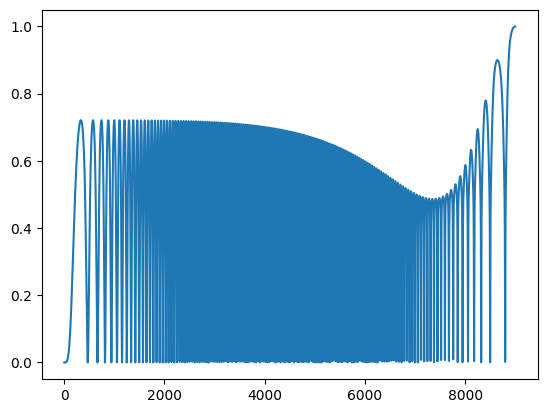

In [3]:
import pandas as pd
import refidx as ri

to_plot = []

for theta in range(9000):
    to_plot.append((coh_tmm('p', [1., 3.5, 1.], [inf, 525000., inf], float(theta*np.pi/18000), 1000.)['R'] + coh_tmm('s', [1., 3.5, 1.], [inf, 525000., inf], float(theta*np.pi/18000), 1000.)['R'])/2)

import matplotlib.pyplot as plt

plt.plot(to_plot)



In [ ]:
import itertools
from pwn import xor
import pwn

print(pwn.__file__)

c = bytes.fromhex("57657535570c1e1c612b3468106a18492140662d2f5967442a2960684d28017931617b1f3637")

random_strs = [b'break it', b'ever', b'ever', b'ever', b'ever', b'ever', b'and you will never', b'is absolutely impenetrable', b'my encryption method']

d = {}          

for combo in range(2**len(random_strs)):
    binary_string = bin(combo)[2:]
    bits = [int(i) for i in binary_string]
    ctxt = c
    for bit, string in zip(bits, random_strs):
        if bit: ctxt = xor(ctxt, string)
    
    print(xor(ctxt, 'Africa!'))
    


/home/ashly_webb/anaconda3/lib/python3.10/site-packages/pwnlib/util/fiddling.py:327: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  strs = [packing.flat(s, word_size = 8, sign = False, endianness = 'little') for s in args]


/home/ashly_webb/anaconda3/lib/python3.10/site-packages/pwn/__init__.py
b'\x16\x03\x07\\4m?]\x07Y]\x0bqKY/S)\x05L\x0e\x18\x016CJ\x01I\x0cNs\x10R\x00Z^PE'
b'tqb=_MV)e+8j\x1ak0[1[`-e8hB!8d(gn\x1ad0r??;e'
b'tqb=_MV)e+8j\x1ak0[1[`-e8hB!8d(gn\x1ad0r??;e'
b'\x11\x07\x07O:;3[\x00]]\x18\x7f\x1dU)T-\x05_\x00N\r0DN\x01Z\x02\x18\x7f\x16U\x04ZM^\x13'
b'tqb=_MV)e+8j\x1ak0[1[`-e8hB!8d(gn\x1ad0r??;e'
b'\x11\x07\x07O:;3[\x00]]\x18\x7f\x1dU)T-\x05_\x00N\r0DN\x01Z\x02\x18\x7f\x16U\x04ZM^\x13'
b'\x11\x07\x07O:;3[\x00]]\x18\x7f\x1dU)T-\x05_\x00N\r0DN\x01Z\x02\x18\x7f\x16U\x04ZM^\x13'
b'tqb=_MV)e+8j\x1ak0[1[`-e8hB!8d(gn\x1ad0r??;e'
b'tqb=_MV)e+8j\x1ak0[1[`-e8hB!8d(gn\x1ad0r??;e'
b'\x11\x07\x07O:;3[\x00]]\x18\x7f\x1dU)T-\x05_\x00N\r0DN\x01Z\x02\x18\x7f\x16U\x04ZM^\x13'
b'\x11\x07\x07O:;3[\x00]]\x18\x7f\x1dU)T-\x05_\x00N\r0DN\x01Z\x02\x18\x7f\x16U\x04ZM^\x13'
b'tqb=_MV)e+8j\x1ak0[1[`-e8hB!8d(gn\x1ad0r??;e'
b'\x11\x07\x07O:;3[\x00]]\x18\x7f\x1dU)T-\x05_\x00N\r0DN\x01Z\x02\x18\x7f\x16U\x04ZM^\x13'
b'tqb=_MV)e+